**Chapter 12 – Deep Computer Vision Using Convolutional Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 12._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/12_deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/12_deep_computer_vision_with_cnns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

If using Colab or Kaggle, a few libraries are not pre-installed so we must install them manually:

In [2]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q torchmetrics

We also need PyTorch ≥ 2.4.0:

In [3]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.4.0")

This chapter can be very slow without a hardware accelerator, so if we can find one, let's use it:

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Let's issue a warning if there's no hardware accelerator available:

In [5]:
if device == "cpu":
    print("Neural nets can be very slow without a hardware accelerator.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Convolutional Layers
## Implementing Convolutional Layers with PyTorch

Let's load two sample images and convert them to a float tensor:

In [7]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images

sample_images = np.stack(load_sample_images()["images"])
sample_images = torch.tensor(sample_images, dtype=torch.float32) / 255

In [8]:
sample_images.shape

torch.Size([2, 427, 640, 3])

Let's permute the dimensions from `[batch, height, width, channels]` to `[batch, channels, height, width]`, as PyTorch expects:

In [9]:
sample_images_permuted = sample_images.permute(0, 3, 1, 2)
sample_images_permuted.shape

torch.Size([2, 3, 427, 640])

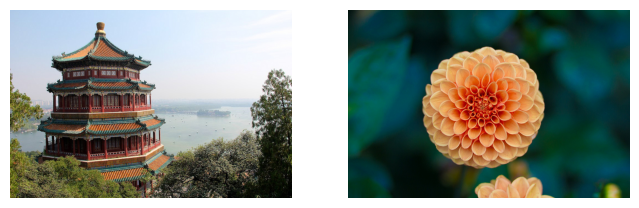

In [10]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

plt.figure(figsize=(8, 4))
for index, image in enumerate(sample_images_permuted):
    plt.subplot(1, 2, index + 1)
    plot_image(image)

Now let's rescale the pixel values from 0-255 to 0-1, and center crop them to small 70×120 images:

In [11]:
import torchvision
import torchvision.transforms.v2 as T

cropped_images = T.CenterCrop((70, 120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

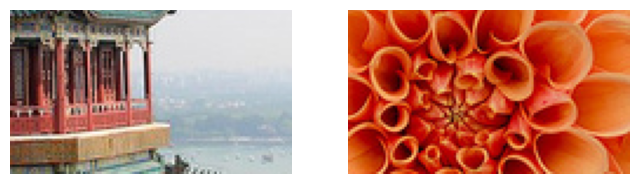

In [12]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_image(cropped_images[0])
plt.subplot(1, 2, 2)
plot_image(cropped_images[1])

In [13]:
import torch.nn as nn

torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

In [14]:
fmaps.shape

torch.Size([2, 32, 64, 114])

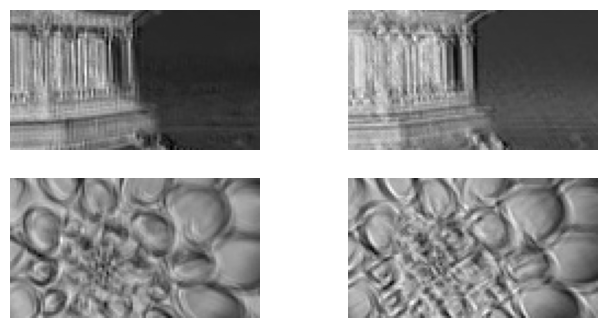

In [15]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(8, 4))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach(), cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [16]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7,
                       padding="same")
fmaps = conv_layer(cropped_images)

In [17]:
fmaps.shape

torch.Size([2, 32, 70, 120])

In [18]:
# extra code – shows the output shape when we set strides=2
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2,
                       padding=3)
fmaps = conv_layer(cropped_images)
fmaps.shape

torch.Size([2, 32, 35, 60])

Let's now look at the shape of the parameters:

In [19]:
conv_layer.weight.shape

torch.Size([32, 3, 7, 7])

In [20]:
conv_layer.bias.shape

torch.Size([32])

In [21]:
# extra code – shows how to use the torch.nn.functional.conv2d() operation
import torch.nn.functional as F

torch.manual_seed(42)
filters = torch.randn([2, 3, 7, 7])
biases = torch.zeros([2])
fmaps = F.conv2d(cropped_images, filters, biases, stride=1, padding="same")

In [22]:
fmaps.shape

torch.Size([2, 2, 70, 120])

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 12–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

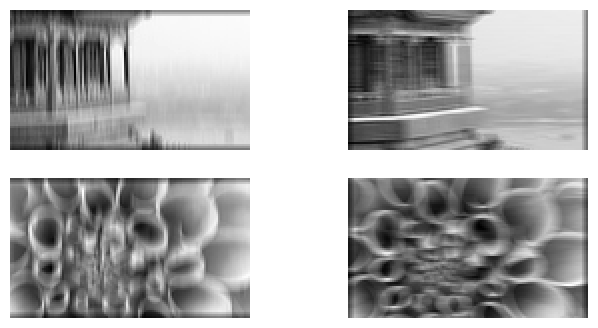

In [23]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 12–5.

plt.figure(figsize=(8, 4))
filters = torch.zeros([2, 3, 7, 7])
filters[0, :, :, 3] = 1
filters[1, :, 3, :] = 1
fmaps = F.conv2d(cropped_images, filters, biases, stride=1, padding="same")

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# Pooling Layers
## Implementing Pooling Layers with PyTorch

**Max pooling**

In [24]:
max_pool = nn.MaxPool2d(kernel_size=2)

In [25]:
output_max = max_pool(cropped_images)

In [26]:
avg_pool = nn.AvgPool2d(kernel_size=2)

In [27]:
output_avg = avg_pool(cropped_images)

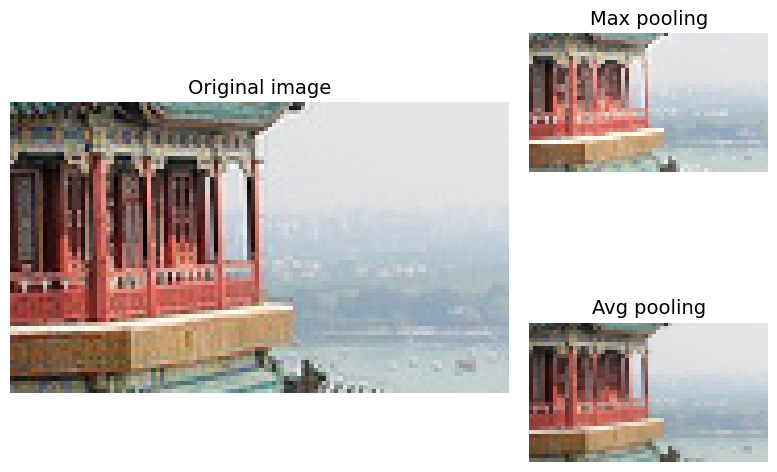

In [28]:
# extra code – this cells shows what max pooling with stride = 2 looks like

fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.imshow(cropped_images[0].permute(1, 2, 0))
ax1.axis('off')
ax1.set_title("Original image")

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.imshow(output_max[0].permute(1, 2, 0))
ax2.axis('off')
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((2, 3), (1, 2))
ax3.imshow(output_avg[0].permute(1, 2, 0))
ax3.axis('off')
ax3.set_title("Avg pooling")

plt.tight_layout()
plt.show()

**Depth-wise pooling**

In [29]:
import torch.nn.functional as F

class DepthMaxPool2(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)  # merge spatial dims
        Z = Z.permute(0, 2, 1)  # switch spatial and channels dims
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                         padding=self.padding)  # compute max pool
        Z = Z.permute(0, 2, 1)  # switch back spatial and channels dims
        return Z.view(batch, -1, height, width)  # unmerge spatial dims

**Global Average Pooling**

First implementation, not very convenient:

In [30]:
global_avg_pool = nn.AvgPool2d(kernel_size=(70, 120))

In [31]:
output = global_avg_pool(cropped_images)

Second implementation (recommended):

In [32]:
global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)

In [33]:
output = global_avg_pool(cropped_images)

Third implementation, without using a module:

In [34]:
output = cropped_images.mean(dim=(2, 3), keepdim=True)

# CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [35]:
from functools import partial

torch.manual_seed(42)  # extra code – ensure reproducibility
DefaultConv2d = partial(nn.Conv2d, kernel_size=3, padding="same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1, out_channels=64, kernel_size=7), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=64, out_channels=128), nn.ReLU(),
    DefaultConv2d(in_channels=128, out_channels=128), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=128, out_channels=256), nn.ReLU(),
    DefaultConv2d(in_channels=256, out_channels=256), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=128), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128, out_features=64), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64, out_features=10),
).to(device)

In [36]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [37]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [38]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [39]:
n_epochs = 20
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/20, train loss: 0.7898, train metric: 0.7096, valid metric: 0.8362
Epoch 2/20, train loss: 0.4629, train metric: 0.8413, valid metric: 0.8720
Epoch 3/20, train loss: 0.3846, train metric: 0.8688, valid metric: 0.8856
Epoch 4/20, train loss: 0.3396, train metric: 0.8840, valid metric: 0.8902
Epoch 5/20, train loss: 0.3132, train metric: 0.8958, valid metric: 0.8964
Epoch 6/20, train loss: 0.2894, train metric: 0.8999, valid metric: 0.9072
Epoch 7/20, train loss: 0.2735, train metric: 0.9067, valid metric: 0.9040
Epoch 8/20, train loss: 0.2537, train metric: 0.9142, valid metric: 0.8992
Epoch 9/20, train loss: 0.2436, train metric: 0.9181, valid metric: 0.9088
Epoch 10/20, train loss: 0.2261, train metric: 0.9236, valid metric: 0.9002
Epoch 11/20, train loss: 0.2196, train metric: 0.9252, valid metric: 0.9154
Epoch 12/20, train loss: 0.2118, train metric: 0.9276, valid metric: 0.9094
Epoch 13/20, train loss: 0.2027, train metric: 0.9298, valid metric: 0.9122
Epoch 14/20, train lo

## LeNet-5

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

## Xception
### Separable Convolutional Layer

In [40]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride=stride,
            padding=padding, groups=in_channels)
        self.pointwise_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, inputs):
        return self.pointwise_conv(self.depthwise_conv(inputs))

# Implementing a ResNet-34 CNN Using PyTorch

In [41]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        DefaultConv2d = partial(
            nn.Conv2d, kernel_size=3, stride=1, padding=1, bias=False)
        self.main_layers = nn.Sequential(
            DefaultConv2d(in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            DefaultConv2d(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
        )
        if stride > 1:
            self.skip_connection = nn.Sequential(
                DefaultConv2d(in_channels, out_channels, kernel_size=1,
                              stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, inputs):
        return F.relu(self.main_layers(inputs) + self.skip_connection(inputs))

In [42]:
class ResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2,
                      padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ]
        prev_filters = 64
        for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            stride = 1 if filters == prev_filters else 2
            layers.append(ResidualUnit(prev_filters, filters, stride=stride))
            prev_filters = filters
        layers += [
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.LazyLinear(10),
        ]
        self.resnet = nn.Sequential(*layers)
    
    def forward(self, inputs):
        return self.resnet(inputs)

In [43]:
torch.manual_seed(42)
model = ResNet34().to(device)
images = torch.randn(2, 3, 224, 224).to(device)
model(images)

tensor([[ 0.1329,  0.1891,  0.1162, -0.9223, -0.0911,  0.0854,  0.6126,  0.0229,
          0.0838, -0.0496],
        [ 0.2894,  0.3137,  0.1142, -1.0163,  0.0233,  0.2133,  0.5497, -0.0836,
          0.1013,  0.0924]], device='mps:0', grad_fn=<LinearBackward0>)

# Using TorchVision's Pretrained Models

In [44]:
weights = torchvision.models.ConvNeXt_Base_Weights.IMAGENET1K_V1
model = torchvision.models.convnext_base(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /Users/ageron/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338M/338M [01:20<00:00, 4.40MB/s]


In [45]:
torch.hub.get_dir()

'/Users/ageron/.cache/torch/hub'

In [46]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [47]:
list(torchvision.models.get_model_weights("convnext_base"))

[ConvNeXt_Base_Weights.IMAGENET1K_V1]

In [48]:
transform = weights.transforms()
preprocessed_images = transform(sample_images_permuted)

In [49]:
model.eval()
with torch.no_grad():
    y_logits = model(preprocessed_images.to(device))

In [50]:
y_logits

tensor([[ 0.9411, -0.3203, -0.3067,  ...,  0.2111,  0.4626, -0.2570],
        [-0.6901, -0.6672, -0.8607,  ...,  0.9288,  4.1106, -0.8371]],
       device='mps:0')

In [51]:
y_logits.shape

torch.Size([2, 1000])

In [52]:
y_pred = torch.argmax(y_logits, dim=1)
y_pred

tensor([698, 985], device='mps:0')

In [53]:
weights.meta.keys()

dict_keys(['min_size', 'categories', 'recipe', '_docs', 'num_params', '_metrics', '_ops', '_file_size'])

In [54]:
class_names = weights.meta["categories"]
[class_names[class_id] for class_id in y_pred]

['palace', 'daisy']

In [55]:
y_top3_logits, y_top3_class_ids = y_logits.topk(k=3, dim=1)
[[class_names[class_id] for class_id in top3] for top3 in y_top3_class_ids]

[['palace', 'monastery', 'lakeside'], ['daisy', 'pot', 'ant']]

In [56]:
y_top3_logits.softmax(dim=1)

tensor([[0.8618, 0.1185, 0.0197],
        [0.8106, 0.0964, 0.0930]], device='mps:0')

# Pretrained Models for Transfer Learning

In [57]:
DefaultFlowers102 = partial(torchvision.datasets.Flowers102, root="datasets",
                            transform=weights.transforms(), download=True)
train_set = DefaultFlowers102(split="train")
valid_set = DefaultFlowers102(split="val")
test_set = DefaultFlowers102(split="test")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345M/345M [05:36<00:00, 1.03MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 501kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15.0k/15.0k [00:00<00:00, 42.6MB/s]


In [58]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [59]:
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

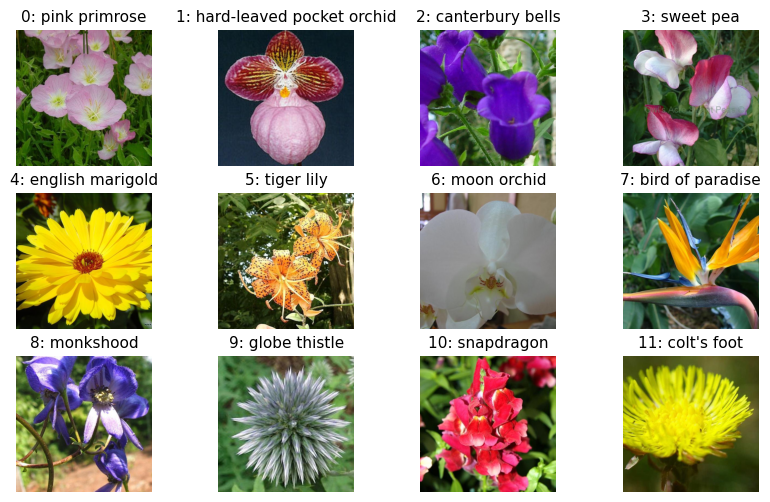

In [60]:
# extra code – displays the 1st image of classes 0 to 11 in the train set

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(500),
])
flowers_to_display = DefaultFlowers102(split="train", transform=transform)
sample_flowers = sorted({y: img for img, y in flowers_to_display}.items())[:12]

plt.figure(figsize=(10, 6))
for class_id, image in sample_flowers:
    if class_id == 12: break
    plt.subplot(3, 4, class_id + 1)
    plot_image(image)
    plt.title(f"{class_id}: {class_names[class_id]}", fontsize=11)

plt.show()

In [61]:
[name for name, child in model.named_children()]

['features', 'avgpool', 'classifier']

In [62]:
model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [63]:
n_classes = 102  # len(class_names) == 102
model.classifier[2] = nn.Linear(1024, n_classes).to(device)

In [64]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [65]:
n_epochs = 5
optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass",
                                 num_classes=102).to(device)
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 4.2971, train metric: 0.1480, valid metric: 0.5461
Epoch 2/5, train loss: 3.0307, train metric: 0.6745, valid metric: 0.7657
Epoch 3/5, train loss: 2.1611, train metric: 0.8206, valid metric: 0.8216
Epoch 4/5, train loss: 1.5776, train metric: 0.9059, valid metric: 0.8480
Epoch 5/5, train loss: 1.1322, train metric: 0.9127, valid metric: 0.8657


In [66]:
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 0.8508, train metric: 0.9569, valid metric: 0.8765
Epoch 2/5, train loss: 0.6929, train metric: 0.9500, valid metric: 0.8765
Epoch 3/5, train loss: 0.5435, train metric: 0.9745, valid metric: 0.8863
Epoch 4/5, train loss: 0.4481, train metric: 0.9745, valid metric: 0.8873
Epoch 5/5, train loss: 0.3547, train metric: 0.9863, valid metric: 0.8843


In [67]:
for param in model.parameters():
    param.requires_grad = True

In [68]:
history = train(model, optimizer, xentropy, accuracy,
                train_loader, valid_loader, n_epochs)

Epoch 1/5, train loss: 0.8000, train metric: 0.7794, valid metric: 0.8078
Epoch 2/5, train loss: 0.1933, train metric: 0.9363, valid metric: 0.8284
Epoch 3/5, train loss: 0.1180, train metric: 0.9637, valid metric: 0.8725
Epoch 4/5, train loss: 0.0692, train metric: 0.9824, valid metric: 0.8431
Epoch 5/5, train loss: 0.1011, train metric: 0.9775, valid metric: 0.8618


In [69]:
import torchvision.transforms.v2 as T

transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Classification and Localization

In [70]:
class FlowerLocator(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.localization_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[2].in_features, 4)
        )

    def forward(self, X):
        features = self.base_model.features(X)
        pool = self.base_model.avgpool(features)
        y_pred_logits = self.base_model.classifier(pool)
        y_pred_bbox = self.localization_head(pool)
        return y_pred_logits, y_pred_bbox

torch.manual_seed(42)
locator_model = FlowerLocator(model).to(device)

Once the model is trained, we can use it to classify and locate the main flower in each image like this:

In [71]:
preproc_images = torch.randn(2, 3, 224, 224)  # a batch of preprocessed images
y_pred_logits, y_pred_bbox = locator_model(preprocessed_images.to(device))

TorchVision has a convenient `BoundingBoxes` class:

In [72]:
import torchvision.tv_tensors

bbox = torchvision.tv_tensors.BoundingBoxes(
    [[377, 199, 248, 262]],  # center x=377, center y=199, width=248, height=262
    format="CXCYWH",  # other possible formats: "XYXY" and "XYWH"
    canvas_size=(500, 754)  # raw image size before preprocessing
)

The transforms API v2 supports bounding boxes:

In [73]:
transform(bbox)

BoundingBoxes([[ 90,  91, 120, 154]], format=BoundingBoxFormat.CXCYWH, canvas_size=(224, 224))

The API also supports nested data structures, and it transforms the images and bounding boxes it finds:

In [74]:
torch.manual_seed(42)

# load the first training image without any preprocessing
first_image = torchvision.datasets.Flowers102(root="datasets", split="train")[0][0]

preproc_image, preproc_target = transform(
    (first_image, {"label": 0, "bbox": bbox})
)
preproc_bbox = preproc_target["bbox"]

Here's how to draw bounding boxes:

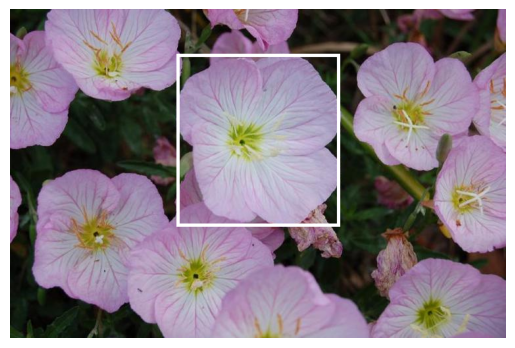

In [75]:
def get_image_with_bbox(image, bbox, width=5, color="white"):
    bbox_xyxy = torchvision.ops.box_convert(bbox, "cxcywh", "xyxy")
    return torchvision.utils.draw_bounding_boxes(
        image, bbox_xyxy, width=width, colors=color)

first_image_ts = T.ToImage()(first_image)
image_with_bbox = get_image_with_bbox(first_image_ts, bbox)
plot_image(image_with_bbox)
plt.show()

Let's look at the transformed image and bounding box:

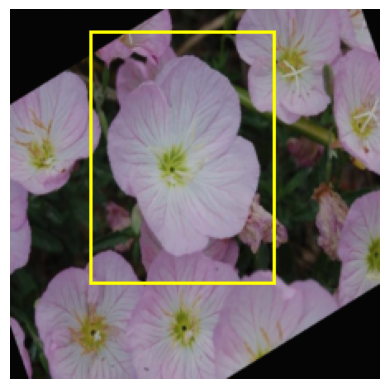

In [76]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    return (image * torch.tensor(std).view(-1, 1, 1)
            + torch.tensor(mean).view(-1, 1, 1))


image_with_bbox2 = get_image_with_bbox(
    denormalize(preproc_image), preproc_bbox, width=2, color="yellow")
plot_image(image_with_bbox2)

Below we can see the transformed bounding box (in yellow), which fits the whole transformed region (in white) rather than the transformed flower. This is why the transformed bounding box ends up being a bit too big. Try running this cell multiple times with different random seeds to see how larger rotations lead to inaccurate bounding boxes:

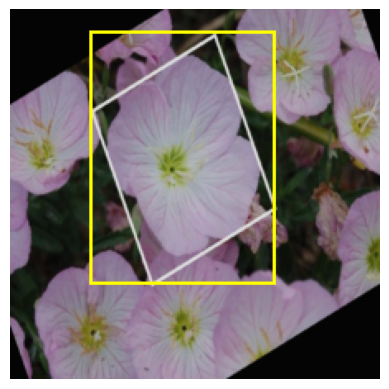

In [77]:
torch.manual_seed(42)

preproc_image2, preproc_target2 = transform(
    (image_with_bbox, {"label": 0, "bbox": bbox})
)
image_and_bbox3 = get_image_with_bbox(
    denormalize(preproc_image2), preproc_target2["bbox"], width=2, color="yellow")
plot_image(image_and_bbox3)

Now let's create a custom dataset to extend the Flowers102 with bounding boxes. We only have two bounding boxes here, but of course with more time and effort this could be extended to the whole dataset, which would allow us to train the `FlowerLocator` model:

In [78]:
bboxes = [
    torchvision.tv_tensors.BoundingBoxes(
        [[377, 199, 248, 262]],
        format="CXCYWH",
        canvas_size=(500, 754)
    ),
    torchvision.tv_tensors.BoundingBoxes(
        [[314, 248, 437, 445]],
        format="CXCYWH",
        canvas_size=(500, 624)  # note that image sizes vary
    )
]

In [79]:
class FlowersWithBBox(torch.utils.data.Dataset):
    def __init__(self, root, bboxes, transform=None, split="train"):
        self.image_dataset = torchvision.datasets.Flowers102(root=root,
                                                             split=split)
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.bboxes)

    def __getitem__(self, index):
        raw_image, label = self.image_dataset[index]
        image = torchvision.tv_tensors.Image(raw_image)
        bbox = self.bboxes[index]
        preproc_image, preproc_bbox = self.transform(image, bbox)
        return preproc_image, {"label": label, "bbox": preproc_bbox}

train_set_with_bboxes = FlowersWithBBox("datasets", bboxes, transform=transform)

In [80]:
train_loader_with_bboxes = DataLoader(train_set_with_bboxes, batch_size=2)
for images, label_and_bbox in train_loader_with_bboxes:
    label = label_and_bbox["label"]
    bbox = label_and_bbox["bbox"]
    # we could train the model here    

# Object Detection

In [81]:
from ultralytics import YOLO

model = YOLO('yolov9m.pt')  # n = nano variant, larger variants are s, m, and x
images = ["https://homl.info/soccer", "https://homl.info/traffic"]
results = model(images)


0: 640x640 5 persons, 2 sports balls, 426.7ms
1: 640x640 3 persons, 7 cars, 1 motorcycle, 11 trucks, 426.7ms
Speed: 1.1ms preprocess, 426.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [82]:
results[0].to_df()

name  class  confidence  \
0  sports ball     32     0.96214   
1       person      0     0.93886   
2       person      0     0.93407   
3       person      0     0.93391   
4       person      0     0.82737   
5       person      0     0.40399   
6  sports ball     32     0.33764   

                                                 box  
0  {'x1': 245.3573, 'y1': 286.03003, 'x2': 300.62...  
1  {'x1': 380.47516, 'y1': 52.46332, 'x2': 548.28...  
2  {'x1': 234.47823, 'y1': 31.53569, 'x2': 365.06...  
3  {'x1': 85.80923, 'y1': 19.24835, 'x2': 247.107...  
4  {'x1': 41.21783, 'y1': 74.47363, 'x2': 175.224...  
5  {'x1': 613.49731, 'y1': 372.65881, 'x2': 639.7...  
6  {'x1': 23.80592, 'y1': 337.59879, 'x2': 46.335...

In [83]:
results[0].summary()[0]

{'name': 'sports ball',
 'class': 32,
 'confidence': 0.96214,
 'box': {'x1': 245.3573, 'y1': 286.03003, 'x2': 300.62506, 'y2': 343.57184}}

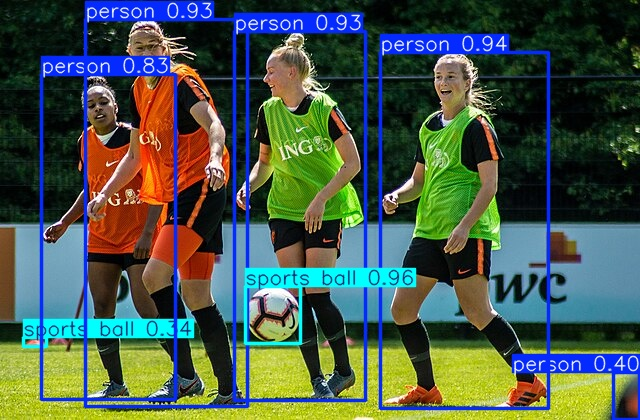

In [84]:
import PIL

results[0].save("my_annotated_soccer.jpg")
PIL.Image.open("my_annotated_soccer.jpg")

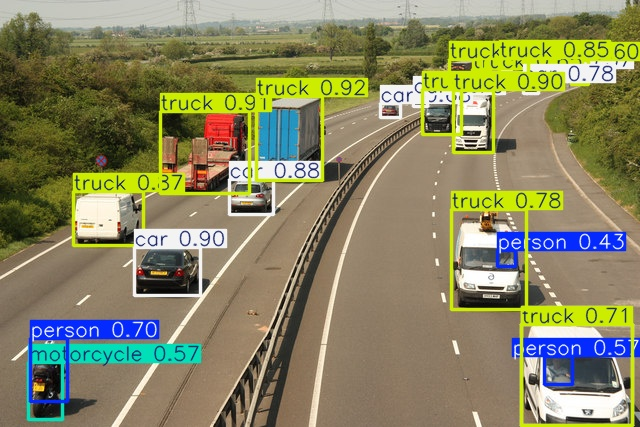

In [85]:
results[1].save("my_annotated_traffic.jpg")
PIL.Image.open("my_annotated_traffic.jpg")

# Object Tracking

In [86]:
my_video = "https://homl.info/cars.mp4"
results = model.track(source=my_video, stream=True, save=True)
for frame_results in results:
    summary = frame_results.summary()  # similar summary as earlier + track id
    track_ids = [obj["track_id"] for obj in summary]
    print("Track ids:", track_ids)


Found https://homl.info/cars.mp4 locally at cars.mp4
video 1/1 (frame 1/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 1 person, 8 cars, 1 bus, 1 truck, 465.0ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
video 1/1 (frame 2/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 1 person, 8 cars, 1 bus, 1 truck, 476.9ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
video 1/1 (frame 3/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 8 cars, 1 bus, 1 truck, 467.5ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
video 1/1 (frame 4/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 459.7ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1 (frame 5/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 465.6ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1 (frame 6/243) /Users/ageron/dev/py/ml/handson-mlp/cars.mp4: 384x640 7 cars, 1 bus, 1 truck, 460.9ms
Track ids: [1, 2, 3, 4, 5, 6, 7, 8, 10]
video 1/1

# Semantic Segmentation

In [87]:
from pathlib import Path
import urllib.request

def download_file(url, path):
    if not path.is_file():
        path.parent.mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(url, path)

download_file("https://homl.info/soccer", Path("datasets/images/soccer.jpg"))

In [88]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
model.eval()

img = PIL.Image.open("soccer.jpg")
transform = weights.transforms()
batch = transform(img).unsqueeze(0)  # unsqueeze() adds a dimension of size 1

with torch.no_grad():
    masks = model(batch)["out"].softmax(dim=1)

class_names = weights.meta["categories"]
name_to_id = {name: class_id for class_id, name in enumerate(class_names)}
mask = masks[0, name_to_id["person"]]

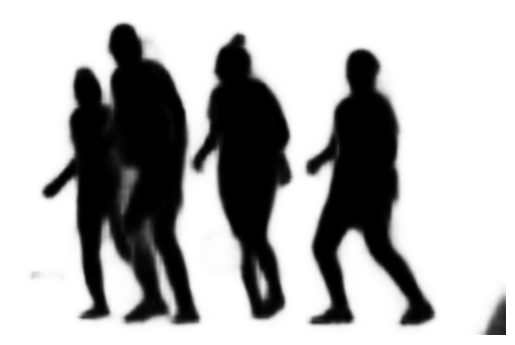

In [89]:
plt.imshow(mask, cmap="binary")
plt.axis('off')
plt.show()

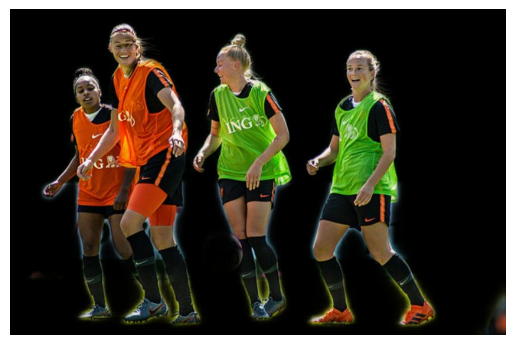

In [90]:
masked_image = mask.unsqueeze(0) * denormalize(batch.squeeze(0))
plot_image(masked_image)

# Extra Material – How mAP Relates to Precision/Recall

In [91]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

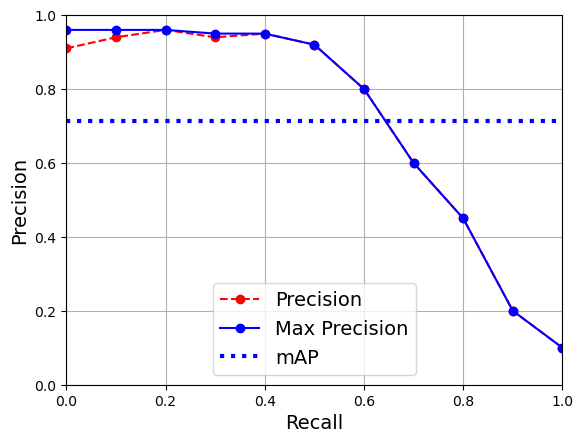

In [92]:
import numpy as np

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "b:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

# Exercise Solutions

## Exercises 1 to 7

1. These are the main advantages of a CNN over a fully connected DNN for image classification:
    * Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
    * When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
    * Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.
2. Let's compute how many parameters the CNN has.
    * Since its first convolutional layer has 3 × 3 kernels, and the input has three channels (red, green, and blue), each feature map has 3 × 3 × 3 weights, plus a bias term. That's 28 parameters per feature map. Since this first convolutional layer has 100 feature maps, it has a total of 2,800 parameters. The second convolutional layer has 3 × 3 kernels and its input is the set of 100 feature maps of the previous layer, so each feature map has 3 × 3 × 100 = 900 weights, plus a bias term. Since it has 200 feature maps, this layer has 901 × 200 = 180,200 parameters. Finally, the third and last convolutional layer also has 3 × 3 kernels, and its input is the set of 200 feature maps of the previous layers, so each feature map has 3 × 3 × 200 = 1,800 weights, plus a bias term. Since it has 400 feature maps, this layer has a total of 1,801 × 400 = 720,400 parameters. All in all, the CNN has 2,800 + 180,200 + 720,400 =  903,400 parameters.<br/>
    * Now let's compute how much RAM this neural network will require (at least) when making a prediction for a single instance. First let's compute the feature map size for each layer. Since we are using a stride of 2 and `"same"` padding, the horizontal and vertical dimensions of the feature maps are divided by 2 at each layer (rounding up if necessary). So, as the input channels are 200 × 300 pixels, the first layer's feature maps are 100 × 150, the second layer's feature maps are 50 × 75, and the third layer's feature maps are 25 × 38. Since 32 bits is 4 bytes and the first convolutional layer has 100 feature maps, this first layer takes up 4 × 100 × 150 × 100 = 6 million bytes (6 MB). The second layer takes up 4 × 50 × 75 × 200 = 3 million bytes (3 MB). Finally, the third layer takes up 4 × 25 × 38 × 400 = 1,520,000 bytes (about 1.5 MB). However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 3 = 9 million bytes (9 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer has not been released yet). But wait, you also need to add the memory occupied by the CNN's parameters! We computed earlier that it has 903,400 parameters, each using up 4 bytes, so this adds 3,613,600 bytes (about 3.6 MB). The total RAM required is therefore (at least) 12,613,600 bytes (about 12.6 MB).<br/>
    * Lastly, let's compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. During training TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the reverse pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50. At this point, let's start counting in megabytes rather than bytes. We computed before that the three layers require respectively 6, 3, and 1.5 MB for each instance. That's a total of 10.5 MB per instance, so for 50 instances the total RAM required is 525 MB. Add to that the RAM required by the input images, which is 50 × 4 × 200 × 300 × 3 = 36 million bytes (36 MB), plus the RAM required for the model parameters, which is about 3.6 MB (computed earlier), plus some RAM for the gradients (we will neglect this since it can be released gradually as backpropagation goes down the layers during the reverse pass). We are up to a total of roughly 525 + 36 + 3.6 = 564.6 MB, and that's really an optimistic bare minimum.
3. If your GPU runs out of memory while training a CNN, here are five things you could try to solve the problem (other than purchasing a GPU with more RAM):
    * Reduce the mini-batch size.
    * Reduce dimensionality using a larger stride in one or more layers.
    * Remove one or more layers.
    * Use 16-bit floats instead of 32-bit floats.
    * Distribute the CNN across multiple devices.
4. A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few (see the previous questions).
5. The main innovations in AlexNet compared to LeNet-5 are that it is much larger and deeper, and it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The main innovation in GoogLeNet is the introduction of _inception modules_, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. ResNet's main innovation is the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative. SENet's main innovation was the idea of using an SE block (a two-layer dense network) after every inception module in an inception network or every residual unit in a ResNet to recalibrate the relative importance of feature maps. Xception's main innovation was the use of depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately. EfficientNet's main innotation was the compound scaling method, to efficiently scale a model to a larger compute budget. Lastly, ConvNeXt's main innovation was modernize CNN architectures based on techniques used with Visual Transformers.
6. Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height (at least above the minimum size). They are most useful for object detection and semantic segmentation because they only need to look at the image once (instead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some dense layers on top, you can convert these dense layers to convolutional layers to create an FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer's input size, with one filter per neuron in the dense layer, and using `"valid"` padding. Generally the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer's. The other dense layers should be converted the same way, but using 1 × 1 filters. It is actually possible to convert a trained CNN this way by appropriately reshaping the dense layers' weight matrices.
7. The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pixel.

TODO